In [1]:
"""
generate_pseudospots_from_h5ad

功能：
- 输入单细胞 h5ad 文件（AnnData 对象）
- 随机采样若干细胞构建 pseudo-spots
- 模拟测序深度/噪声（Poisson / NB）
- 输出：
    - spots_counts.csv  (spots x genes)
    - spots_proportions.csv (ground truth)
    - spots_metadata.csv (spot_id, x, y, n_cells_in_spot)
"""

import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as st
import anndata as ad

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ========== 用户参数 ==========
h5ad_file = "/home/pxy/home/pxy/scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad"
outdir = "sim_pseudospots_split"
n_spots_total = 1000
min_cells_per_spot = 1
max_cells_per_spot = 10
random_seed = 42
celltype_key = "cell_types"   # AnnData.obs 中存细胞类型的列名
# ==============================

In [3]:
np.random.seed(random_seed)
os.makedirs(outdir, exist_ok=True)


In [4]:
# 读取 scRNA-seq 数据
adata = sc.read_h5ad(h5ad_file)
if 'X' in adata.layers:
    counts_mat = adata.layers['X']
else:
    counts_mat = adata.X
if hasattr(counts_mat, "toarray"):
    counts_mat = counts_mat.toarray()
counts_mat = counts_mat.astype(float)

cell_ids = np.array(adata.obs_names)
cell_types = adata.obs[celltype_key].astype(str).values
unique_ct = np.unique(cell_types)
gene_names = np.array(adata.var_names)

In [5]:
# ---------- 按单细胞来源划分 ----------
n_cells = len(cell_ids)
train_cell_ids = np.random.choice(cell_ids, size=int(n_cells*0.7), replace=False)
test_cell_ids = np.setdiff1d(cell_ids, train_cell_ids)

print(f"Train cells: {len(train_cell_ids)}, Test cells: {len(test_cell_ids)}")

Train cells: 10492, Test cells: 4497


In [ ]:
# def make_pseudospots(cell_ids_pool, n_spots, prefix="spot"):
#     spots_counts = []
#     spots_props = []
#     spots_meta = []
#     spot_ids = []

#     for i in range(n_spots):
#         spot_id = f"{prefix}_{i}"
#         n_cells_in_spot = np.random.randint(min_cells_per_spot, max_cells_per_spot+1)
#         chosen_cells = np.random.choice(cell_ids_pool, size=n_cells_in_spot, replace=True)
#         idx = [np.where(cell_ids==cid)[0][0] for cid in chosen_cells]
#         spot_counts = counts_mat[idx,:].sum(axis=0)

#         # proportions
#         ct_counts = pd.Series(cell_types[idx]).value_counts()
#         ct_props = {ct: ct_counts.get(ct,0)/n_cells_in_spot for ct in unique_ct}

#         spots_counts.append(spot_counts)
#         spots_props.append(ct_props)
#         spots_meta.append({
#             "spot_id": spot_id,
#             "n_cells_in_spot": n_cells_in_spot,
#             "x": np.random.uniform(0,1000),
#             "y": np.random.uniform(0,1000),
#         })
#         spot_ids.append(spot_id)

#     spots_counts = pd.DataFrame(spots_counts, columns=gene_names, index=spot_ids)
#     spots_props = pd.DataFrame(spots_props, index=spot_ids).fillna(0.0)
#     spots_meta = pd.DataFrame(spots_meta).set_index("spot_id")
#     return spots_counts, spots_props, spots_meta

In [6]:
def make_pseudospots(cell_ids_pool, n_spots, prefix="spot",
                    noise_model="nb", dispersion_spot=20.0, depth_variation_sd=0.15):
    spots_counts = []
    spots_props = []
    spots_meta = []
    spot_ids = []

    for i in range(n_spots):
        spot_id = f"{prefix}_{i}"
        n_cells_in_spot = np.random.randint(min_cells_per_spot, max_cells_per_spot+1)
        chosen_cells = np.random.choice(cell_ids_pool, size=n_cells_in_spot, replace=True)
        idx = [np.where(cell_ids==cid)[0][0] for cid in chosen_cells]
        spot_counts_raw = counts_mat[idx,:].sum(axis=0)

        # 深度变化
        depth_factor = max(np.random.normal(1.0, depth_variation_sd), 0.1)
        spot_counts_raw = spot_counts_raw * depth_factor

        # 技术噪声
        if noise_model == "poisson":
            spot_counts = np.random.poisson(lam=np.clip(spot_counts_raw, 0, None))
        elif noise_model == "nb":
            r = dispersion_spot
            p = r / (r + spot_counts_raw + 1e-8)
            spot_counts = st.nbinom.rvs(r, p)
        else:
            spot_counts = spot_counts_raw  # 不加噪声

        # proportions
        ct_counts = pd.Series(cell_types[idx]).value_counts()
        ct_props = {ct: ct_counts.get(ct,0)/n_cells_in_spot for ct in unique_ct}

        spots_counts.append(spot_counts)
        spots_props.append(ct_props)
        spots_meta.append({
            "spot_id": spot_id,
            "n_cells_in_spot": n_cells_in_spot,
            "x": np.random.uniform(0,1000),
            "y": np.random.uniform(0,1000),
        })
        spot_ids.append(spot_id)

    spots_counts = pd.DataFrame(spots_counts, columns=gene_names, index=spot_ids)
    spots_props = pd.DataFrame(spots_props, index=spot_ids).fillna(0.0)
    spots_meta = pd.DataFrame(spots_meta).set_index("spot_id")
    return spots_counts, spots_props, spots_meta

In [7]:
# ---------- 生成 pseudo-spots ----------
# train+val 70% spots, test 30%
n_trainval = int(n_spots_total * 0.7)
n_test = n_spots_total - n_trainval

# trainval_counts, trainval_props, trainval_meta = make_pseudospots(train_cell_ids, n_trainval)
# test_counts, test_props, test_meta = make_pseudospots(test_cell_ids, n_test)

trainval_counts, trainval_props, trainval_meta = make_pseudospots(
    train_cell_ids, n_trainval, noise_model="nb", dispersion_spot=20.0, depth_variation_sd=0.15)
test_counts, test_props, test_meta = make_pseudospots(
    test_cell_ids, n_test, noise_model="nb", dispersion_spot=20.0, depth_variation_sd=0.15)

# 再拆 train/val
train_ids, val_ids = np.split(np.random.permutation(trainval_meta.index), 
                              [int(len(trainval_meta)*0.7)])

train_counts = trainval_counts.loc[train_ids]
val_counts = trainval_counts.loc[val_ids]
train_props = trainval_props.loc[train_ids]
val_props = trainval_props.loc[val_ids]
train_meta = trainval_meta.loc[train_ids]
val_meta = trainval_meta.loc[val_ids]

In [8]:
def make_adata(spots_counts, spots_props, spots_meta, prefix=""):
    # obs
    obs = spots_meta.copy()

    # var（基因信息）
    var = pd.DataFrame(index=spots_counts.columns)
    var["gene_name"] = spots_counts.columns  # 基因名
    var["n_cells_by_counts"] = (spots_counts > 0).sum(axis=0).values
    var["mean_counts"] = spots_counts.mean(axis=0).values
    var["total_counts"] = spots_counts.sum(axis=0).values
    var["log1p_mean_counts"] = np.log1p(var["mean_counts"])
    var["log1p_total_counts"] = np.log1p(var["total_counts"])

    # AnnData
    adata = ad.AnnData(
        X=spots_counts.values,
        obs=obs,
        var=var
    )

    # ground truth 细胞比例
    for col in spots_props.columns:
        adata.obs[col] = spots_props[col].values

    # 空间坐标
    adata.obsm["spatial"] = adata.obs[["x", "y"]].values

    return adata

In [9]:
train_adata = make_adata(train_counts, train_props, train_meta)
val_adata   = make_adata(val_counts, val_props, val_meta)
test_adata  = make_adata(test_counts, test_props, test_meta)

train_adata.write_h5ad("./sim_pseudospots_split/train.h5ad")
val_adata.write_h5ad("./sim_pseudospots_split/val.h5ad")
test_adata.write_h5ad("./sim_pseudospots_split/test.h5ad")


In [11]:
st_train = sc.read_h5ad("./sim_pseudospots_split/train.h5ad")
st_val = sc.read_h5ad("./sim_pseudospots_split/val.h5ad")
st_test = sc.read_h5ad("./sim_pseudospots_split/test.h5ad")


In [ ]:
# print(st_train)
# print(st_val)
# print(st_test)


AnnData object with n_obs × n_vars = 489 × 1888
    obs: 'n_cells_in_spot', 'x', 'y', 'CD4 T cells', 'CD8 T cells', 'Cxcl9-high monocytes', 'Cycling B/T cells', 'GD T cells', 'Ifit3-high B cells', 'Ly6-high monocytes', 'Macrophages', 'Mature B cells', 'Migratory DCs', 'NK cells', 'Tregs', 'cDC1s', 'cDC2s', 'pDCs'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 211 × 1888
    obs: 'n_cells_in_spot', 'x', 'y', 'CD4 T cells', 'CD8 T cells', 'Cxcl9-high monocytes', 'Cycling B/T cells', 'GD T cells', 'Ifit3-high B cells', 'Ly6-high monocytes', 'Macrophages', 'Mature B cells', 'Migratory DCs', 'NK cells', 'Tregs', 'cDC1s', 'cDC2s', 'pDCs'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 300 × 1888
    obs: 'n_cells_in_spot', 'x', 'y', 'CD4 T cells

In [ ]:
# # ========== 用户参数 ==========
# h5ad_file = "/home/pxy/home/pxy/scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad"  # 输入 h5ad 文件
# outdir = "sim_pseudospots_h5ad"
# n_spots = 1000
# min_cells_per_spot = 1
# max_cells_per_spot = 10
# random_seed = 42
# noise_model = "nb"  # "nb" 或 "poisson"
# dispersion_spot = 20.0  # NB dispersion
# depth_variation_sd = 0.15
# make_coords = True
# coords_box = (0, 0, 1000, 1000)
# celltype_key = "cell_types"  # AnnData.obs 中存细胞类型的列名
# # ======================================

In [3]:
# sc_adata = sc.read_h5ad(h5ad_file)
# sc_adata.obs.head()

In [ ]:
# np.random.seed(random_seed)
# os.makedirs(outdir, exist_ok=True)

In [ ]:
# # 1. 读取 h5ad
# adata = sc.read_h5ad(h5ad_file)
# if 'X' in adata.layers:
#     counts_mat = adata.X.copy()
# else:
#     counts_mat = adata.X.copy()

# # 确保是 numpy array
# if hasattr(counts_mat, "toarray"):
#     counts_mat = counts_mat.toarray()
# counts_mat = counts_mat.astype(float)

# cell_ids = adata.obs_names.to_list()
# gene_names = adata.var_names.to_list()

# if celltype_key not in adata.obs.columns:
#     raise ValueError(f"{celltype_key} 不在 adata.obs.columns 中，请检查列名")
# cell_types = adata.obs[celltype_key].astype(str).to_list()
# unique_ct = sorted(list(set(cell_types)))

# n_cells, n_genes = counts_mat.shape

In [ ]:
# # 假设 sc_meta 有列 'cell_id' 和 'donor' 或 'batch'
# cells = adata['cell_id'].unique()
# np.random.seed(0)
# # 按单细胞来源划分
# train_cells = np.random.choice(cells, size=int(len(cells)*0.7), replace=False)
# test_cells = np.setdiff1d(cells, train_cells)

In [ ]:
# # 2. 生成 pseudo-spots
# spot_ids = [f"Spot{i+1}" for i in range(n_spots)]
# spots_counts = np.zeros((n_spots, n_genes), dtype=int)
# spots_props = np.zeros((n_spots, len(unique_ct)), dtype=float)
# spots_meta = []

# for s in range(n_spots):
#     n_in_spot = np.random.randint(min_cells_per_spot, max_cells_per_spot + 1)
#     sampled_idx = np.random.choice(n_cells, size=n_in_spot, replace=False)
#     sampled_cells = counts_mat[sampled_idx, :]
#     mixed = sampled_cells.sum(axis=0)
#     # 加深度变化
#     depth_factor = max(np.random.normal(1.0, depth_variation_sd), 0.1)
#     mixed = mixed * depth_factor
#     # 采样噪声
#     if noise_model == "poisson":
#         spot_counts = np.random.poisson(lam=np.clip(mixed, 0, None))
#     elif noise_model == "nb":
#         r = dispersion_spot
#         p = r / (r + mixed + 1e-8)
#         spot_counts = st.nbinom.rvs(r, p)
#     else:
#         raise ValueError("noise_model must be 'poisson' or 'nb'")
#     spots_counts[s, :] = spot_counts
#     # ground truth proportions
#     types_sampled = [cell_types[idx] for idx in sampled_idx]
#     vals, cnts = np.unique(types_sampled, return_counts=True)
#     prop = {ct: 0.0 for ct in unique_ct}
#     for v, c in zip(vals, cnts):
#         prop[v] = c / n_in_spot
#     spots_props[s, :] = [prop[ct] for ct in unique_ct]
#     # spot metadata
#     x = np.random.uniform(coords_box[0], coords_box[2]) if make_coords else 0
#     y = np.random.uniform(coords_box[1], coords_box[3]) if make_coords else 0
#     spots_meta.append((spot_ids[s], x, y, n_in_spot))

In [ ]:
# # 3. 保存 CSV
# spots_counts_df = pd.DataFrame(spots_counts, index=spot_ids, columns=gene_names)
# spots_props_df = pd.DataFrame(spots_props, index=spot_ids, columns=unique_ct)
# spots_meta_df = pd.DataFrame(spots_meta, columns=["spot_id", "x", "y", "n_cells_in_spot"])

# spots_counts_df.to_csv(os.path.join(outdir, "spots_counts.csv"))
# spots_props_df.to_csv(os.path.join(outdir, "spots_proportions.csv"))
# spots_meta_df.to_csv(os.path.join(outdir, "spots_metadata.csv"), index=False)

# # 可选：保存原始单细胞 counts + meta
# # sc_counts_df = pd.DataFrame(counts_mat, index=cell_ids, columns=gene_names)
# # sc_meta_df = adata.obs[[celltype_key]]
# # sc_counts_df.to_csv(os.path.join(outdir, "sc_reference_counts_filtered.csv"))
# # sc_meta_df.to_csv(os.path.join(outdir, "sc_reference_meta_filtered.csv"))

# print("生成完成，文件保存至:", outdir)
# print("spots_counts shape:", spots_counts_df.shape)

生成完成，文件保存至: sim_pseudospots_h5ad
spots_counts shape: (1000, 1888)


In [ ]:
# # 输入 CSV
# spots_counts_file = "./sim_pseudospots_h5ad/spots_counts.csv"
# spots_props_file = "./sim_pseudospots_h5ad/spots_proportions.csv"
# spots_meta_file = "./sim_pseudospots_h5ad/spots_metadata.csv"

# # 输出 H5AD
# h5ad_out = "pseudo_spots_with_genes.h5ad"

# # 读取 CSV
# counts_df = pd.read_csv(spots_counts_file, index_col=0)   # spots x genes
# meta_df = pd.read_csv(spots_meta_file)                    # spot_id, x, y, n_cells_in_spot
# props_df = pd.read_csv(spots_props_file, index_col=0)     # ground truth cell type proportions

# # 对齐
# counts_df = counts_df.loc[meta_df['spot_id']]
# props_df = props_df.loc[meta_df['spot_id']]

# # 构建 AnnData
# adata = anndata.AnnData(
#     X = counts_df.values,
#     obs = meta_df.set_index('spot_id'),
#     var = pd.DataFrame(index=counts_df.columns)  # 这里存基因信息
# )

# # 添加 ground-truth 细胞类型比例
# for col in props_df.columns:
#     adata.obs[col] = props_df[col].values

# # ------------------ 新增：计算每个基因统计信息 ------------------
# X = adata.X
# if hasattr(X, "toarray"):  # 如果是稀疏矩阵
#     X = X.toarray()

# # 计算每个基因在多少个 spot 表达
# adata.var['n_cells_by_counts'] = np.sum(X > 0, axis=0)
# # 计算每个基因平均 counts
# adata.var['mean_counts'] = np.mean(X, axis=0)
# # 可选：添加 gene_symbols 列方便查看
# adata.var['gene_symbols'] = adata.var.index

# # 添加空间坐标
# adata.obsm["spatial"] = adata.obs[['x','y']].values

# # 保存
# adata.write_h5ad(h5ad_out)
# print(f"Saved pseudo-spots H5AD with gene info: {h5ad_out}")
# print(adata)

Saved pseudo-spots H5AD with gene info: pseudo_spots_with_genes.h5ad
AnnData object with n_obs × n_vars = 1000 × 1888
    obs: 'x', 'y', 'n_cells_in_spot', 'CD4 T cells', 'CD8 T cells', 'Cxcl9-high monocytes', 'Cycling B/T cells', 'GD T cells', 'Ifit3-high B cells', 'Ly6-high monocytes', 'Macrophages', 'Mature B cells', 'Migratory DCs', 'NK cells', 'Tregs', 'cDC1s', 'cDC2s', 'pDCs'
    var: 'n_cells_by_counts', 'mean_counts', 'gene_symbols'
    obsm: 'spatial'
               n_cells_by_counts  mean_counts   gene_symbols
1300017J02Rik                 25        0.118  1300017J02Rik
1500009L16Rik                 32        0.135  1500009L16Rik
1600010M07Rik                 41        0.165  1600010M07Rik
1700025G04Rik                348        1.901  1700025G04Rik
1700097N02Rik                230        1.171  1700097N02Rik
...                          ...          ...            ...
Zfp36                        935       17.524          Zfp36
Zfp366                        97        0.374  

In [ ]:
# adata_pseudo = sc.read_h5ad("pseudo_spots_with_genes.h5ad")

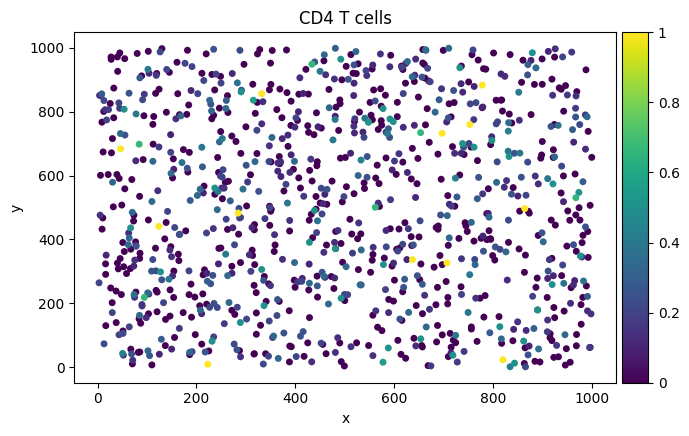

In [ ]:
# adata = sc.read_h5ad("pseudo_spots_with_genes.h5ad")

# 查看前 5 个 spot 的 metadata
# print(adata)

# 可视化其中一个细胞类型的空间分布
# 绘制某个细胞类型比例的空间分布
# ct = "CD4 T cells"
# sc.pl.scatter(adata, x='x', y='y', color=ct, size=100)

In [ ]:
# mouse_cd4_genes = ["Cd4", "Il7r", "Tbx21", "Gata3", "Rorc", "Foxp3"]
# for g in mouse_cd4_genes:
#     if g in adata.var_names:
#         print(f"{g} 在数据中")
#     else:
#         print(f"{g} 不在数据中")


Cd4 在数据中
Il7r 在数据中
Tbx21 不在数据中
Gata3 在数据中
Rorc 在数据中
Foxp3 在数据中


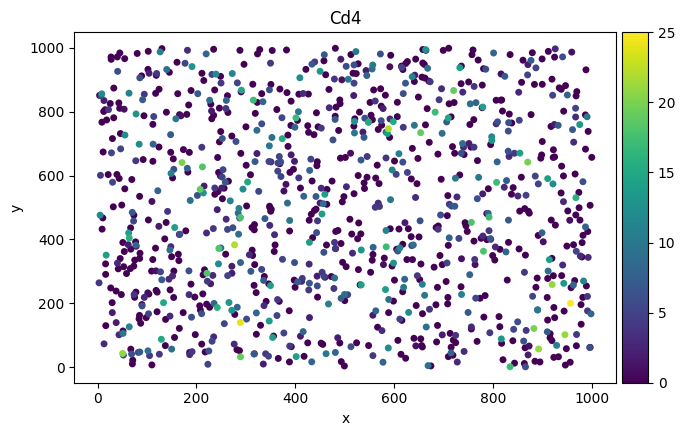

In [ ]:
# gene = "Cd4"  # 确认存在后
# adata.obs[gene] = adata[:, gene].X.toarray().flatten() if hasattr(adata.X, "toarray") else adata[:, gene].X.flatten()
# sc.pl.scatter(adata, x='x', y='y', color=gene, size=100)
